In [33]:
!pip install cloudscraper #this isn't needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 2.8 MB/s eta 0:00:00


# Webscraper + ML Pipeline
#### by Daniel Michel
id: 2022/02556


In [226]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import json
import cloudscraper

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [51]:
session = requests.Session()
header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36"
}
#number of pages 55
cars = []
for page in range(1,65):
  url = f"https://www.carsdirect.com/used_cars/listings/sedan?pageNum={page}"
  pagedata = requests.get(url, headers=header)
  time.sleep(2)
  soup = BeautifulSoup(pagedata.content, "html.parser")
  carsInPage = soup.find_all('div', class_='listingBlock')
  for car in carsInPage:
    carInfo = car.find('p', class_='ymmListRowTitle').text
    carYear = carInfo.split(' ')[0]
    carMake = carInfo.split(' ')[1]
    carModel = carInfo.split(' ')[2]
    carTrim = car.find('p', class_='ymmListRowTrim').text.strip()

    carPriceMileInfo = car.find('div', class_='infoPriceMilesBlock')
    if carPriceMileInfo:
      carMileLine = carPriceMileInfo.find('div', class_='mileLine')
      carMilage = carMileLine.text.strip() if carMileLine else 'N/A'
      carPrice = carPriceMileInfo.find('div', class_='priceLine').text.strip()
    else:
      carMilage = carPrice = "N/A"

    cars.append({
        'Year': carYear,
        'Make': carMake,
        'Model': carModel,
        'Trim': carTrim,
        'Milage': carMilage,
        'Price': carPrice,
    })


print(len(cars))
print(cars[0])

816
{'Year': '2025', 'Make': 'Kia', 'Model': 'K5', 'Trim': 'GT-Line', 'Milage': '19,346 mi', 'Price': '$29,595'}


In [252]:
df = pd.DataFrame(cars)


In [253]:
def format_price(price_str):
  if price_str=='Contact Dealer':
    return ''
  return price_str.replace('$', '').replace(',', '')

df["Price"] = df['Price'].apply(format_price)

In [254]:
def fixMissingTrim(trim):
  return 'base' if trim == '' else trim

df["Trim"] = df['Trim'].apply(fixMissingTrim)

In [255]:
def formatMilage(milage):
  return milage.replace('mi', '').replace(',', '').replace('N/A','')

df["Milage"] = df['Milage'].apply(formatMilage)

In [256]:
df['Price'] = pd.to_numeric(df['Price'])
df['Milage'] = pd.to_numeric(df['Milage'])
df['Year'] = pd.to_numeric(df['Year'])

In [257]:
df.head()

,Year,Make,Model,Trim,Milage,Price
0,2025,Kia,K5,GT-Line,19346.0,29595.0
1,2025,Kia,K5,GT-Line,122.0,31995.0
2,2024,Kia,Forte,GT-Line,11284.0,23495.0
3,2024,Toyota,Camry,base,14531.0,32295.0
4,2023,Kia,Forte,GT-Line,38501.0,20495.0


In [258]:
df.isnull().sum()

,0
Year,0
Make,0
Model,0
Trim,0
Milage,1
Price,17


In [259]:
df.describe()

,Year,Milage,Price
count,816.000000,815.000000,799.000000
mean,2020.840686,43133.561963,24430.063830
std,3.580672,32078.266601,10346.520638
min,1999.000000,14.000000,5445.000000
25%,2019.000000,18938.000000,18774.000000
50%,2022.000000,37006.000000,22432.000000
75%,2023.000000,60377.000000,27989.500000
max,2025.000000,193256.000000,99876.000000


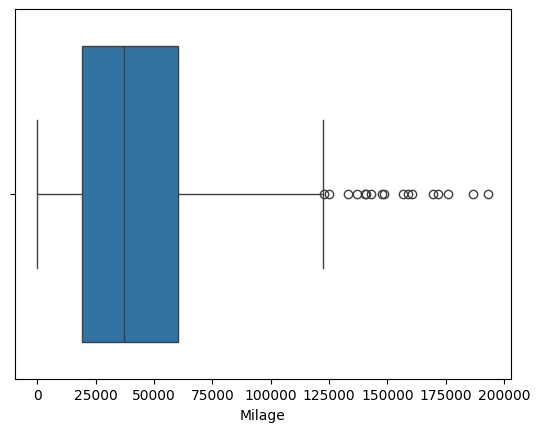

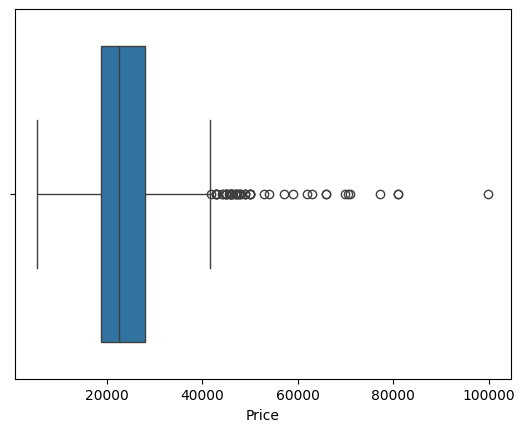

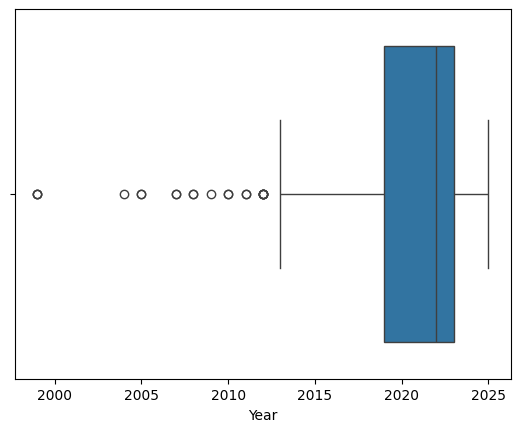

In [260]:
sns.boxplot(x=df['Milage'])
plt.show()
sns.boxplot(x=df['Price'])
plt.show()
sns.boxplot(x=df['Year'])
plt.show()

In [261]:
df.to_csv('cars.csv', index=False)

In [262]:
print(df.columns)
print(df.dtypes)

Index(['Year', 'Make', 'Model', 'Trim', 'Milage', 'Price'], dtype='object')
Year        int64
Make       object
Model      object
Trim       object
Milage    float64
Price     float64
dtype: object


In [263]:
y = df['Price']
X = df.drop(columns='Price')

In [264]:
price_imputer = SimpleImputer(strategy='mean')
y_imputed = price_imputer.fit_transform(y.values.reshape(-1, 1))

In [265]:
print(len(y_imputed))
print(len(X))

816
816


In [266]:

X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.2)

In [267]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

dataPreprocessor = ColumnTransformer([
    ('num', num_transformer, ['Milage']),
    ('cat', cat_transformer, ['Make', 'Model', 'Trim'])
])

# I AM STILL WORKING ON IT 😭😭😭
## I WILL EDIT MY SUBMISSION, TRUST ME


In [269]:
model = Pipeline(steps=[##da mesh sh8alll
      ('preprocessor', dataPreprocessor),
      ('model', model)
])

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Milage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Model', 'Trim'])])),
                ('model', RandomForestRegressor())])

In [273]:
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

results={}
for name, model in models.items():

  model_pipeline = Pipeline(steps=[
      ('preprocessor', dataPreprocessor),
      ('model', model)
  ])

  model_pipeline.fit(X_train, y_train)

  test_score = model_pipeline.score(X_test, y_test)
  print(f"Test score (R^2): {test_score}")
  predictions = model_pipeline.predict(X_test)
  print(f"Predictions: {predictions[:5]}")

  MSE = mean_squared_error(y_test, predictions)
  print(f"Mean Squared Error (MSE): {MSE}")

  results[name] = {'MSE': MSE, 'R2': test_score}



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test score (R^2): 0.6046418912859455
Predictions: [28694.96       25441.14382979 24644.48       22123.24
 38253.22382979]
Mean Squared Error (MSE): 28648659.4773151
Test score (R^2): 0.5121686654876495
Predictions: [[25350.51254195]
 [28708.35834382]
 [25957.55597921]
 [21603.89333874]
 [29901.90056553]]
Mean Squared Error (MSE): 35349505.87017441


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Test score (R^2): 0.5725215801641312
Predictions: [29801.02229145 24161.11898109 24161.11898109 23858.95475319
 35110.22394681]
Mean Squared Error (MSE): 30976179.35196074
Test score (R^2): 0.6311611393755071
Predictions: [27705.375 27502.098 25312.342 23275.535 40120.812]
Mean Squared Error (MSE): 26727006.951751802
{'Random Forest': {'MSE': 28648659.4773151, 'R2': 0.6046418912859455}, 'Linear Regression': {'MSE': 35349505.87017441, 'R2': 0.5121686654876495}, 'Gradient Boosting': {'MSE': 30976179.35196074, 'R2': 0.5725215801641312}, 'XGBoost': {'MSE': 26727006.951751802, 'R2': 0.6311611393755071}}


In [277]:
#This is all chat gpt tbh, bas it just sorted based on Rsqrd and MSE

# Sort models by R^2 in descending order (higher R^2 is better)
sorted_by_r2 = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)

# Print the sorted results
print("Models sorted by R^2:")
for model_name, metrics in sorted_by_r2:
    print(f"{model_name} - R^2: {metrics['R2']}, MSE: {metrics['MSE']}")

# Sort models by MSE in ascending order (lower MSE is better)
sorted_by_mse = sorted(results.items(), key=lambda x: x[1]['MSE'])

# Print the sorted results
print("\nModels sorted by MSE:")
for model_name, metrics in sorted_by_mse:
    print(f"{model_name} - MSE: {metrics['MSE']}, R^2: {metrics['R2']}")


Models sorted by R^2:
XGBoost - R^2: 0.6311611393755071, MSE: 26727006.951751802
Random Forest - R^2: 0.6046418912859455, MSE: 28648659.4773151
Gradient Boosting - R^2: 0.5725215801641312, MSE: 30976179.35196074
Linear Regression - R^2: 0.5121686654876495, MSE: 35349505.87017441

Models sorted by MSE:
XGBoost - MSE: 26727006.951751802, R^2: 0.6311611393755071
Random Forest - MSE: 28648659.4773151, R^2: 0.6046418912859455
Gradient Boosting - MSE: 30976179.35196074, R^2: 0.5725215801641312
Linear Regression - MSE: 35349505.87017441, R^2: 0.5121686654876495


XGBoost was The best performing model...